# COVID-19 Pandemic

![](https://www.statnews.com/wp-content/uploads/2020/02/Coronavirus-CDC-645x645.jpg)

Source = https://www.statnews.com/wp-content/uploads/2020/02/Coronavirus-CDC-645x645.jpg


# Load the libraries

In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
sns.set()
import numpy as np # linear algebra
 # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  *
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import DenseNet121, VGG19, ResNet50
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import PIL.Image
import matplotlib.pyplot as mpimg
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_df = pd.read_csv('../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv')
train_df.shape

(5910, 6)

In [3]:
train_df.head(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5910 non-null   int64 
 1   X_ray_image_name        5910 non-null   object
 2   Label                   5910 non-null   object
 3   Dataset_type            5910 non-null   object
 4   Label_2_Virus_category  69 non-null     object
 5   Label_1_Virus_category  4334 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.2+ KB


# 2. Missing Values

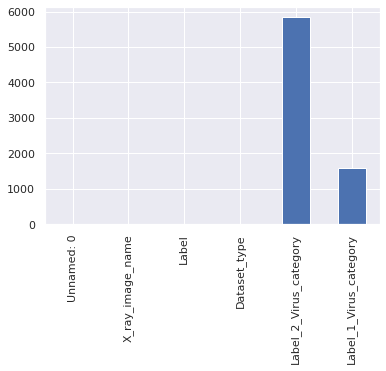

In [5]:
missing_vals = train_df.isnull().sum()
missing_vals.plot(kind = 'bar')

In [6]:
train_df.dropna(how = 'all')
train_df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [7]:
#impute unknown to null data points, we don't wanna see those ugly null values
train_df.fillna('unknown', inplace=True)
train_df.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

In [8]:
train_data = train_df[train_df['Dataset_type'] == 'TRAIN']
test_data = train_df[train_df['Dataset_type'] == 'TEST']
assert train_data.shape[0] + test_data.shape[0] == train_df.shape[0]
print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")
test_data.sample(10)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5752,5775,person83_bacteria_412.jpeg,Pnemonia,TEST,unknown,bacteria
5850,5873,person1_virus_11.jpeg,Pnemonia,TEST,unknown,Virus
5348,5371,IM-0070-0001.jpeg,Normal,TEST,unknown,unknown
5394,5417,NORMAL2-IM-0313-0001.jpeg,Normal,TEST,unknown,unknown
5469,5492,NORMAL2-IM-0123-0001.jpeg,Normal,TEST,unknown,unknown
5502,5525,NORMAL2-IM-0359-0001.jpeg,Normal,TEST,unknown,unknown
5550,5573,person157_bacteria_740.jpeg,Pnemonia,TEST,unknown,bacteria
5675,5698,person112_bacteria_539.jpeg,Pnemonia,TEST,unknown,bacteria
5858,5881,person173_bacteria_831.jpeg,Pnemonia,TEST,unknown,bacteria
5567,5590,person150_bacteria_715.jpeg,Pnemonia,TEST,unknown,bacteria


Let's fill the missing values with 'unknown'

# Understanding some cols

In [9]:
print((train_df['Label_1_Virus_category']).value_counts())
print('--------------------------')
print((train_df['Label_2_Virus_category']).value_counts())

bacteria          2777
unknown           1576
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64
--------------------------
unknown          5841
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64


**Label_2 virus category consists of COVID-19 cases!!**

# Let's Visualize Label_2 virus category

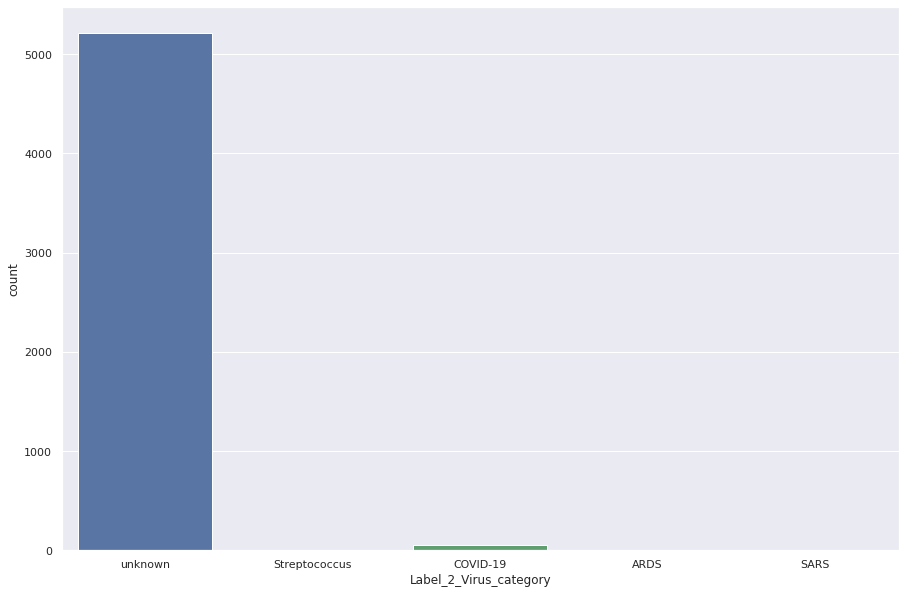

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(train_data['Label_2_Virus_category']);

# 4. Display Images

In [11]:
test_img_dir = '/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
train_img_dir = '/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

sample_train_images = list(os.walk(train_img_dir))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(train_img_dir, x), sample_train_images))

sample_test_images = list(os.walk(test_img_dir))[0][2][:8]
sample_test_images = list(map(lambda x: os.path.join(test_img_dir, x), sample_test_images))

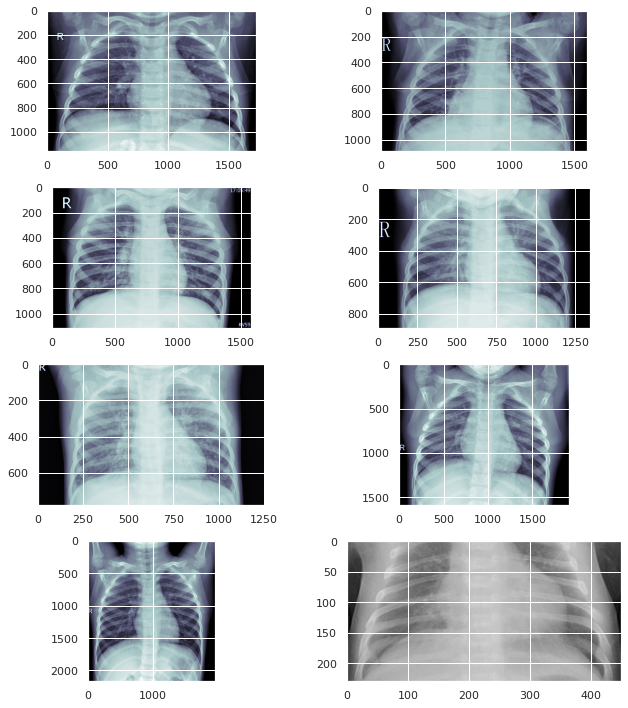

In [13]:
plt.figure(figsize = (10,10))
for iterator, filename in enumerate(sample_train_images):
    image = PIL.Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image, cmap=plt.cm.bone)

plt.tight_layout()

# Histogram analysis of Images

**For COVID-19 cases**

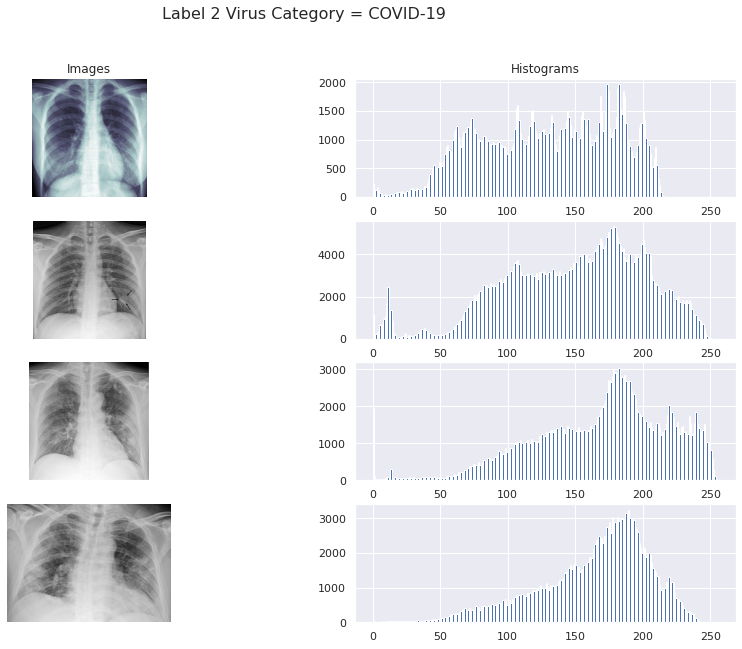

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(15, 10))


covid_path = train_data[train_data['Label_2_Virus_category']=='COVID-19']['X_ray_image_name'].values

sample_covid_path = covid_path[:4]
sample_covid_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_covid_path))

for row, file in enumerate(sample_covid_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image, cmap=plt.cm.bone)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label 2 Virus Category = COVID-19', size=16)
plt.show()

**Normal Histogram images**

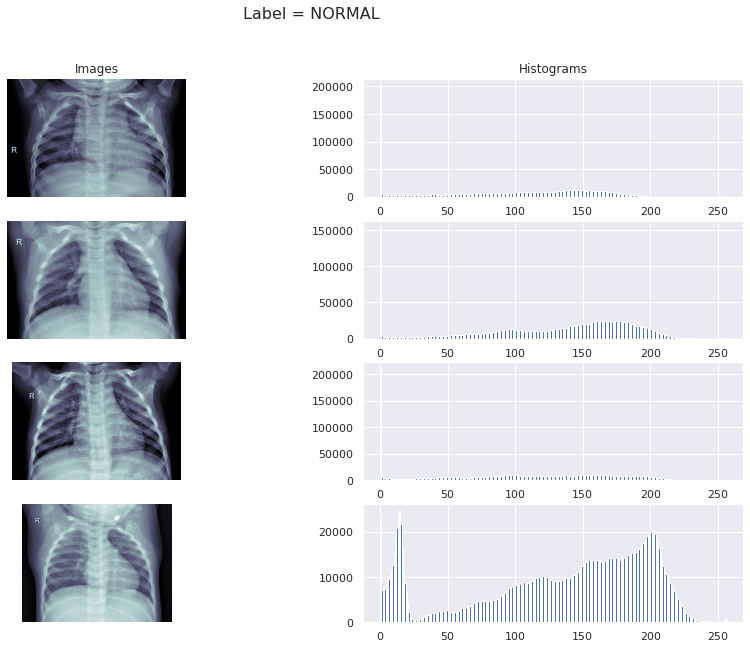

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(15, 10))


normal_path = train_data[train_data['Label']=='Normal']['X_ray_image_name'].values

sample_normal_path = normal_path[:4]
sample_normal_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_normal_path))

for row, file in enumerate(sample_normal_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image, cmap=plt.cm.bone)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label = NORMAL', size=16)
plt.show()

# 5. Image Augmentation

In [16]:
#remove Pnuemonia with unknown value
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') &
                               (train_data['Label_2_Virus_category'] == 'COVID-19'))]

# add a target and class feature
final_train_data['class'] = final_train_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')
test_data['class'] = test_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')

final_train_data['target'] = final_train_data.Label.apply(lambda x: 0 if x=='Normal' else 1)
test_data['target'] = test_data.Label.apply(lambda x: 0 if x=='Normal' else 1)
#get the important features
final_train_data = final_train_data[['X_ray_image_name', 'class', 'target', 'Label_2_Virus_category']]
final_test_data = test_data[['X_ray_image_name', 'class', 'target']]

test_data['Label'].value_counts()

Pnemonia    390
Normal      234
Name: Label, dtype: int64

**Credits to [John Wendell](https://www.kaggle.com/delllectron/deep-learning-on-covid-19) for an awesome implementation**

In [22]:
#create a imagegenerator for for augmentation
datagen =  ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
)
def read_img(filename, size, path):
    img = image.load_img(os.path.join(path, filename), target_size=size)
    #convert image to array
    img = img_to_array(img) / 255
    return img

In [23]:
#augment the images labeled with covid-19 to balance the data

corona_df = final_train_data[final_train_data['Label_2_Virus_category'] == 'COVID-19']
with_corona_augmented = []

#create a function for augmentation
def augment(name):
    img = read_img(name, (255,255), train_img_dir)
    i = 0
    for batch in tqdm(datagen.flow(tf.expand_dims(img, 0), batch_size=32)):
        with_corona_augmented.append(tf.squeeze(batch).numpy())
        if i == 20:
            break
        i =i+1

#apply the function
corona_df['X_ray_image_name'].apply(augment)

20it [00:00, 59.16it/s]              
20it [00:00, 61.47it/s]              
20it [00:00, 62.62it/s]              
20it [00:00, 45.51it/s]              
20it [00:00, 38.29it/s]              
20it [00:00, 58.95it/s]              
20it [00:00, 59.08it/s]              
20it [00:00, 60.17it/s]              
20it [00:00, 61.57it/s]              
20it [00:00, 62.97it/s]              
20it [00:00, 62.54it/s]              
20it [00:00, 63.79it/s]              
20it [00:00, 64.53it/s]              
20it [00:00, 63.31it/s]              
20it [00:00, 63.92it/s]              
20it [00:00, 62.89it/s]              
20it [00:00, 63.35it/s]              
20it [00:00, 64.24it/s]              
20it [00:00, 62.25it/s]              
20it [00:00, 64.78it/s]              
20it [00:00, 63.53it/s]              
20it [00:00, 62.75it/s]              
20it [00:00, 63.54it/s]              
20it [00:00, 66.22it/s]              
20it [00:00, 65.12it/s]              
20it [00:00, 64.12it/s]              
20it [00:00,

5221    None
5222    None
5223    None
5224    None
5225    None
5226    None
5227    None
5228    None
5229    None
5230    None
5237    None
5238    None
5239    None
5240    None
5242    None
5243    None
5244    None
5245    None
5246    None
5247    None
5248    None
5249    None
5250    None
5251    None
5252    None
5253    None
5254    None
5255    None
5256    None
5257    None
5258    None
5259    None
5260    None
5261    None
5262    None
5263    None
5264    None
5265    None
5266    None
5267    None
5268    None
5269    None
5270    None
5271    None
5272    None
5273    None
5274    None
5275    None
5276    None
5277    None
5278    None
5279    None
5280    None
5281    None
5282    None
5283    None
5284    None
5285    None
Name: X_ray_image_name, dtype: object

In [24]:
# extract the image from traing data and test data, then convert them as array
train_arrays = [] 
final_train_data['X_ray_image_name'].apply(lambda x: train_arrays.append(read_img(x, (255,255), train_img_dir)))
test_arrays = []
final_test_data['X_ray_image_name'].apply(lambda x: test_arrays.append(read_img(x, (255,255), test_img_dir)))

5286    None
5287    None
5288    None
5289    None
5290    None
        ... 
5905    None
5906    None
5907    None
5908    None
5909    None
Name: X_ray_image_name, Length: 624, dtype: object

In [25]:
#concatenate the training data labels and the labels for augmented images
y_train = np.concatenate((np.int64(final_train_data['target'].values), np.ones(len(with_corona_augmented), dtype=np.int64)))

In [26]:
# Converting Data to tensors
train_tensors = tf.convert_to_tensor(np.concatenate((np.array(train_arrays), np.array(with_corona_augmented))))
test_tensors  = tf.convert_to_tensor(np.array(test_arrays))
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(final_test_data['target'].values)

train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors, y_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_tensors, y_test_tensor))

In [28]:
BATCH_SIZE = 16
BUFFER = 1000

train_batches = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

# ResNet 50

In [29]:
#define input shape
INPUT_SHAPE = (255,255,3) 

#get the pretrained model
base_model = tf.keras.applications.ResNet50(input_shape= INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#set the trainable method of covolution layer as false
# why set to false?? because we don't want to mess up the pretrained weights of the model!!
base_model.trainable = False

94773248/94765736 [==============================] - 2s 0us/step


In [30]:
#let's try to pass an image to the model to verify the output shape
for i,l in train_batches.take(1):
    pass
base_model(i).shape

TensorShape([16, 8, 8, 2048])

In [31]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

In [32]:
#add a earlystopping callback to stop the training if the model is not learning anymore
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#let's just choose adam as our optimizer, we all love adam anyway.
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


In [33]:
model.fit(train_batches, epochs=10, validation_data=test_batches, callbacks=[callbacks])

Train for 164 steps, validate for 39 steps
Epoch 1/10
164/164 [==============================] - 19s 116ms/step - loss: 0.4954 - accuracy: 0.9599 - val_loss: 8.4148 - val_accuracy: 0.6250
Epoch 2/10
164/164 [==============================] - 14s 84ms/step - loss: 0.6100 - accuracy: 0.9641 - val_loss: 10.2551 - val_accuracy: 0.6250
Epoch 3/10
164/164 [==============================] - 14s 84ms/step - loss: 0.2511 - accuracy: 0.9691 - val_loss: 10.3883 - val_accuracy: 0.6250


In [34]:
#predict the test data
pred = model.predict_classes(np.array(test_arrays))
#let's print a classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data['target'], pred.flatten()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



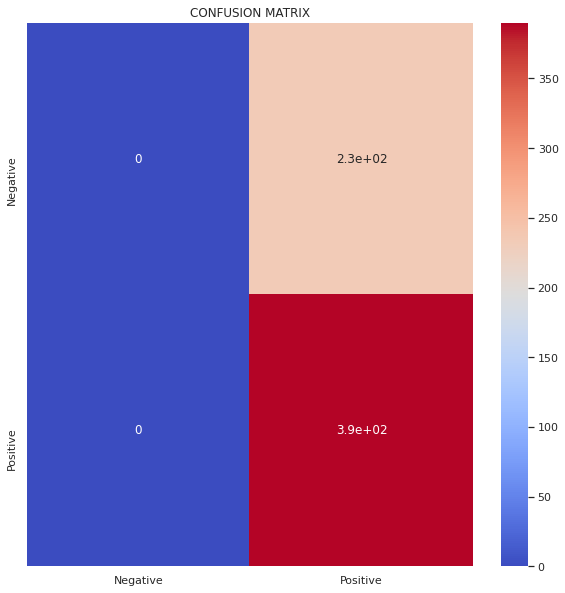

In [36]:
con_mat = confusion_matrix(test_data['target'], pred.flatten())
plt.figure(figsize = (10,10))
plt.title('CONFUSION MATRIX')
sns.heatmap(con_mat, cmap='coolwarm',
            yticklabels=['Negative', 'Positive'],
            xticklabels=['Negative', 'Positive'],
            annot=True);

**WORK IN PROGRESS**

# 8. References
Thanks to some amazing notebooks I was able to learn how to display images in an orderly fashion and was able to apply transfer learning CNN in COVID related applications.
1. https://www.kaggle.com/adityam1311/covid-19-x-ray-images-eda-models/notebook
2. https://www.kaggle.com/eswarchandt/covid-19-detection-from-lung-x-rays